**Greg Burns - 6/23/25 - Spaceship Titanic

# 1) Project Setup

## 1a) Install Libraries

In [26]:
# 1a) Install Libraries
!pip install --upgrade --quiet xgboost lightgbm catboost optuna shap category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


## 1b) Import Libraries

In [29]:
# 1b) Import Libraries

# --- Core Libraries for Data Handling and Operations ---
import numpy as np
import pandas as pd
import os
import warnings
import random

# --- Libraries for Data Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-Learn Preprocessing ---
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
import category_encoders as ce

# --- Scikit-Learn Metrics ---
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import loguniform, randint

# --- Classification Models ---

# 1. Baseline and Simple Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# 2. Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# 3. Support Vector Machines (SVM)
from sklearn.svm import SVC

# 4. Neural Networks and Gaussian Processes
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF # For GaussianProcessClassifier

# 5. Ensemble Models (Bagging and Boosting)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier

# 6. Advanced Gradient Boosting Machines
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 7. Stacking and Voting Ensembles
from sklearn.ensemble import VotingClassifier, StackingClassifier

# --- Notebook and Display Settings ---
# Set a consistent style for all plots
sns.set_style("whitegrid")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
pd.set_option('display.max_columns', 50)

# Ignore warnings to keep the notebook clean
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


## 1c) Mount Drive

In [3]:
# 1c) Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# set your working directory
BASE_PATH = '/content/drive/MyDrive/Kaggle1'
os.makedirs(BASE_PATH, exist_ok=True)
os.chdir(BASE_PATH)
print("Working directory:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory: /content/drive/MyDrive/Kaggle1


# 2) Data Load & Review  

## 2a) Load Data  

In [42]:
# 2a) Load Data

# Load datasets
train = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
test  = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
sub   = pd.read_csv(os.path.join(BASE_PATH, 'sample_submission.csv'))

# Display dataset shapes
print(f"Train shape: {train.shape}")
print(f"Test  shape: {test.shape}")
print(f"Sub   shape: {sub.shape}")

Train shape: (8693, 14)
Test  shape: (4277, 13)
Sub   shape: (4277, 2)


## 2b) Review Data

In [43]:
# 2b) Review Data

# Check for duplicate rows
dup_count = train.duplicated().sum()
print(f"\nDuplicate rows in train: {dup_count}")

# Target distribution
print("\nTransported value counts:")
print(train['Transported'].value_counts())
print("\nTransported proportions:")
print(train['Transported'].value_counts(normalize=True))

# Data types and non-null percentages
dtype_df = pd.DataFrame({
    'dtype': train.dtypes,
    'non-null %': train.notnull().mean().mul(100)
})
print("\nData types and non-null percentages:")
display(dtype_df)

# Missing value percentages
missing_df = train.isnull().mean().mul(100).sort_values(ascending=False).to_frame('Missing %')
print("\nMissing value percentages:")
display(missing_df)

# Unique counts for categorical features
cat_features = train.select_dtypes(include=['object','bool','category']).columns.tolist()
print("\nUnique counts (categorical features):")
for col in cat_features:
    print(f" - {col}: {train[col].nunique()}")

# Numeric summary statistics
print("\nNumeric feature summary:")
display(train.describe())


Duplicate rows in train: 0

Transported value counts:
Transported
True     4378
False    4315
Name: count, dtype: int64

Transported proportions:
Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

Data types and non-null percentages:


,dtype,non-null %
PassengerId,object,100.000000
HomePlanet,object,97.687795
CryoSleep,object,97.503739
Cabin,object,97.710802
Destination,object,97.906361
Age,float64,97.940872
VIP,object,97.664788
RoomService,float64,97.917865
FoodCourt,float64,97.894858
ShoppingMall,float64,97.607270



Missing value percentages:


,Missing %
CryoSleep,2.496261
ShoppingMall,2.392730
VIP,2.335212
HomePlanet,2.312205
Name,2.300702
Cabin,2.289198
VRDeck,2.162660
Spa,2.105142
FoodCourt,2.105142
Destination,2.093639



Unique counts (categorical features):
 - PassengerId: 8693
 - HomePlanet: 3
 - CryoSleep: 2
 - Cabin: 6560
 - Destination: 3
 - VIP: 2
 - Name: 8473
 - Transported: 2

Numeric feature summary:


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


**Observations**
* ...

## 2c) Initial EDA

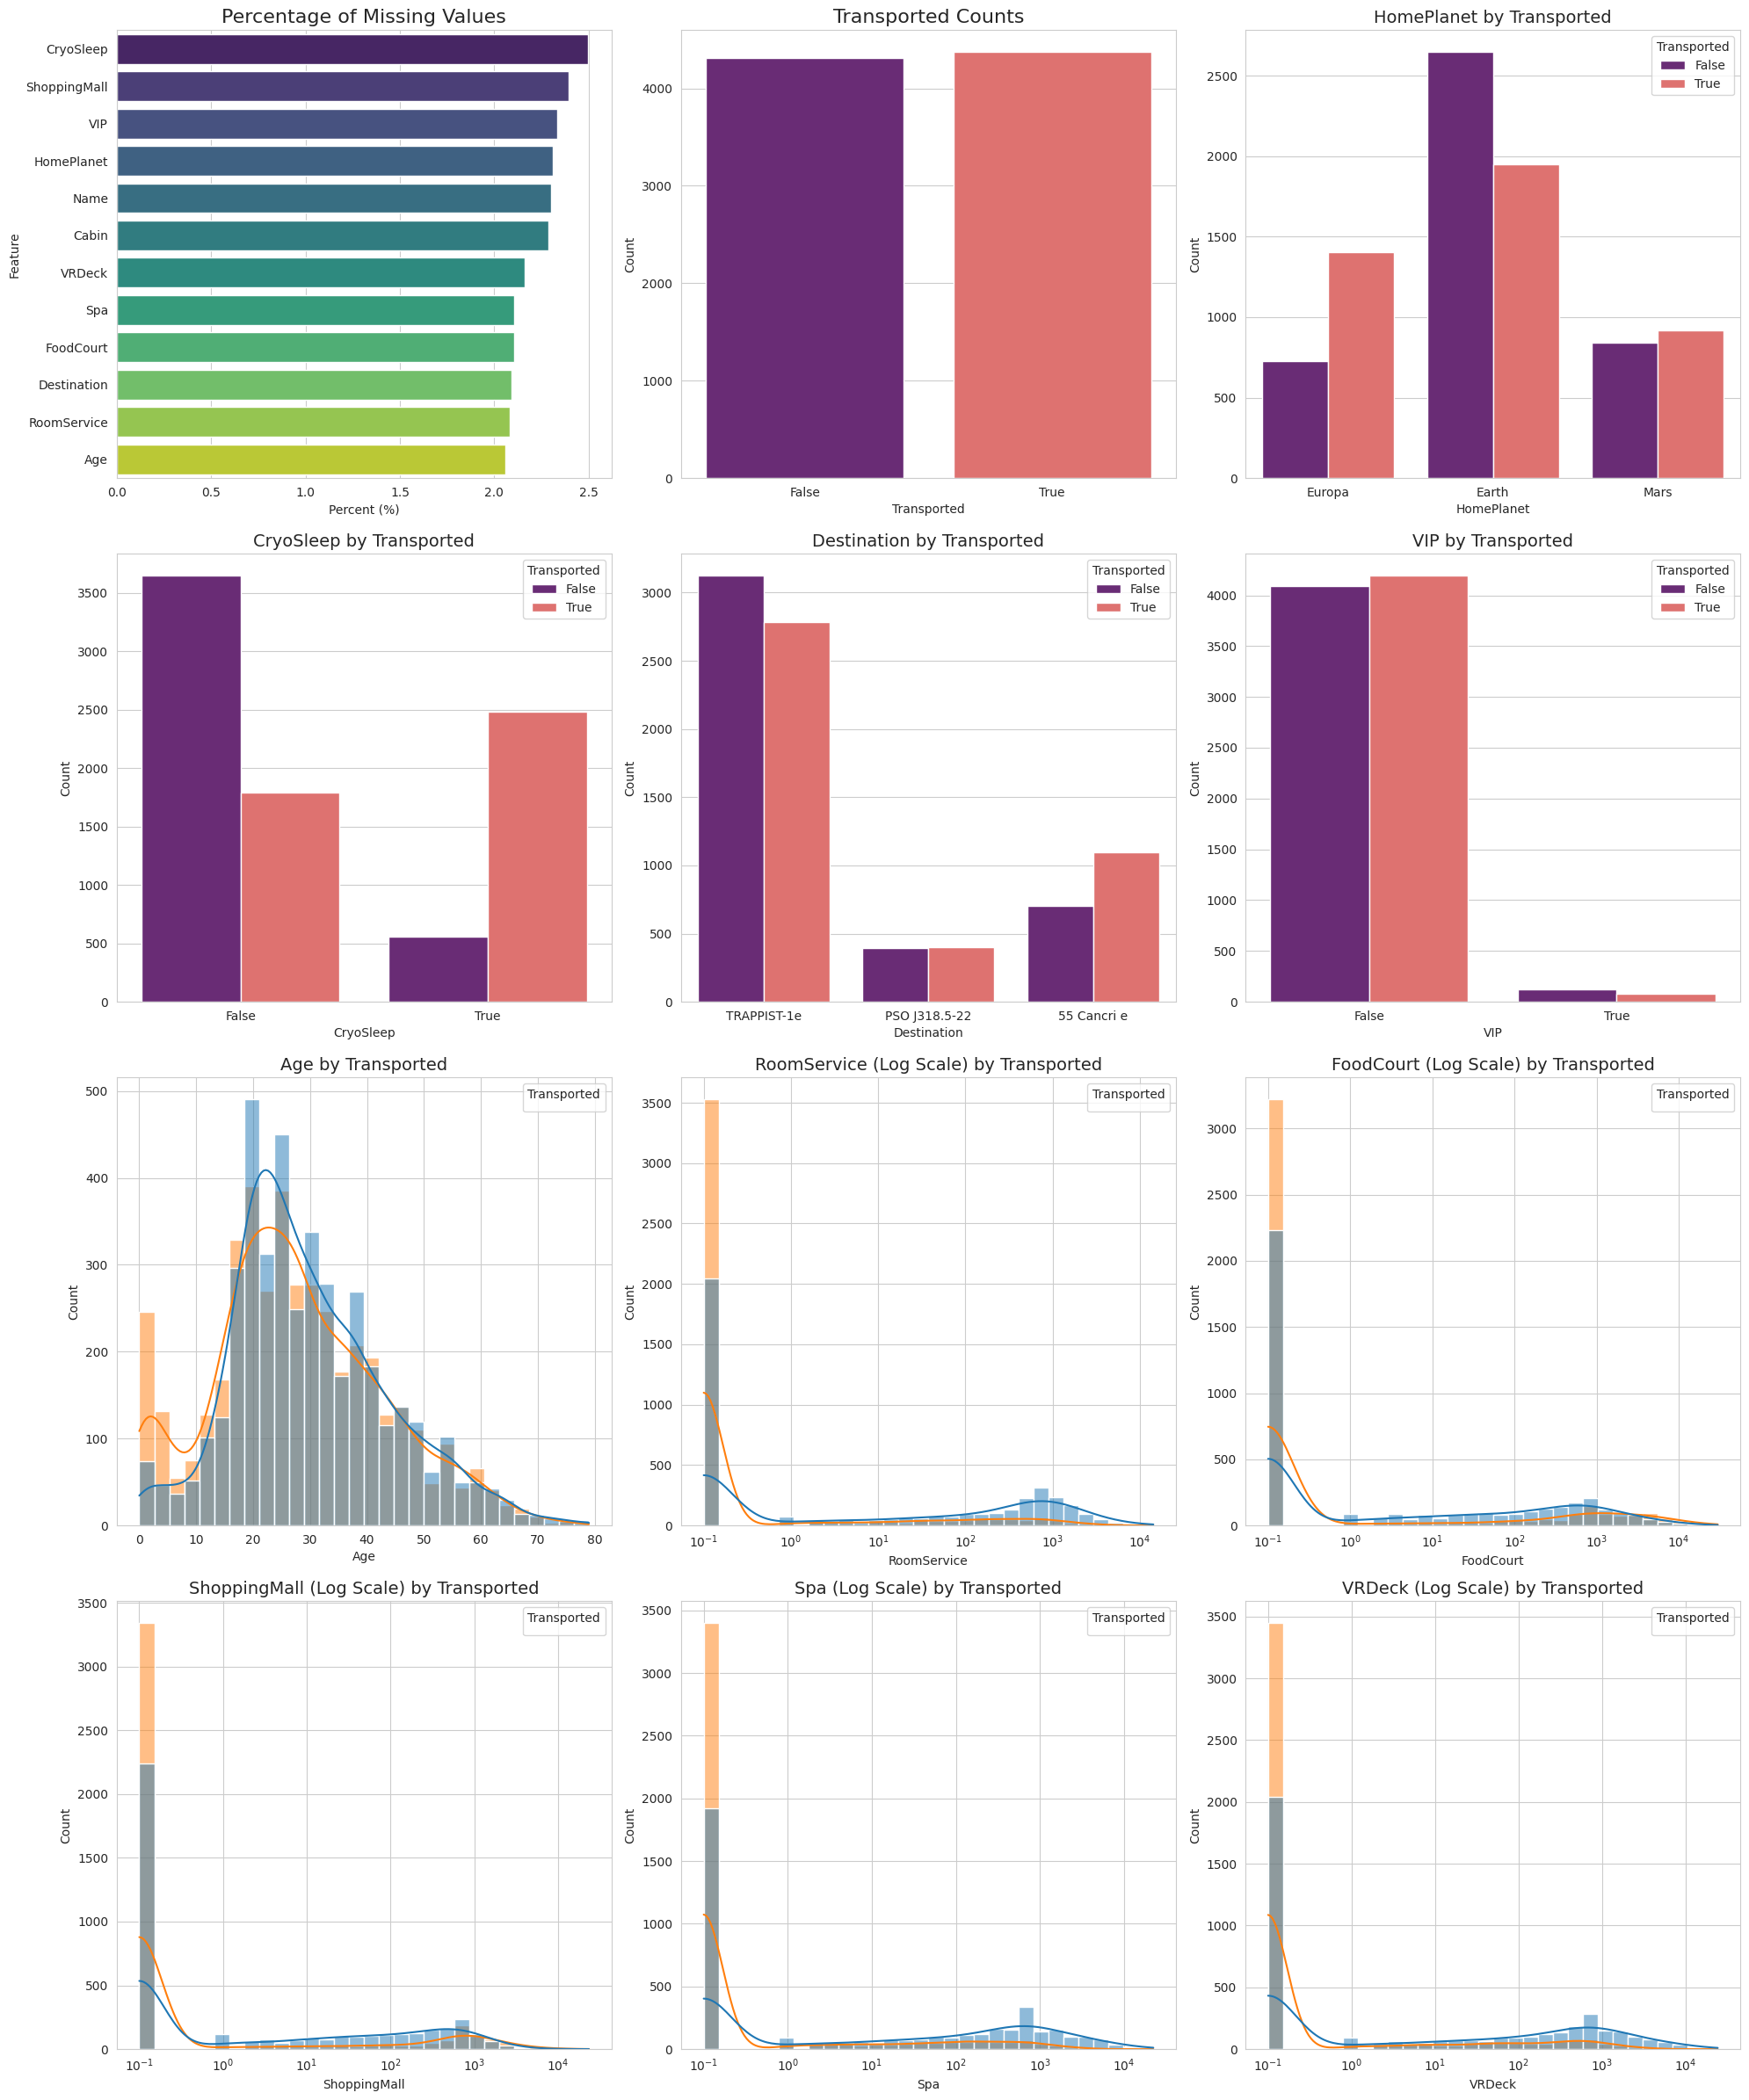

In [44]:
# Data for plots
missing_to_plot = train.isnull().mean().mul(100).sort_values(ascending=False)
missing_to_plot = missing_to_plot[missing_to_plot > 0]
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Prepare numeric features for plotting (avoid log(0))
plot_data = train.copy()
for feat in numerical_features:
    if feat != 'Age':
        plot_data[f'{feat}_plt'] = plot_data[feat].replace(0, 0.1)
    else:
        plot_data[f'{feat}_plt'] = plot_data[feat]

# Create 4×3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 24))
axes = axes.flatten()

# Define the sequence of plots
plot_sequence = ['missing', 'target'] + cat_features + numerical_features

for ax, feat in zip(axes, plot_sequence):
    if feat == 'missing':
        sns.barplot(x=missing_to_plot.values, y=missing_to_plot.index, ax=ax, palette='viridis')
        ax.set_title('Percentage of Missing Values', fontsize=16)
        ax.set_xlabel('Percent (%)')
        ax.set_ylabel('Feature')
    elif feat == 'target':
        sns.countplot(x=train['Transported'], ax=ax, palette='magma')
        ax.set_title('Transported Counts', fontsize=16)
        ax.set_xlabel('Transported')
        ax.set_ylabel('Count')
    elif feat in cat_features:
        sns.countplot(x=train[feat], hue=train['Transported'], ax=ax, palette='magma')
        ax.set_title(f'{feat} by Transported', fontsize=14)
        ax.set_xlabel(feat)
        ax.set_ylabel('Count')
        ax.legend(title='Transported')
    else:
        plot_col = f'{feat}_plt'
        sns.histplot(
            data=plot_data, x=plot_col, hue='Transported',
            bins=30, kde=True, ax=ax, log_scale=(feat != 'Age')
        )
        title = f'{feat}{" (Log Scale)" if feat != "Age" else ""} by Transported'
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(feat)
        ax.set_ylabel('Count')
        ax.legend(title='Transported')

plt.tight_layout()
plt.show()

**Observations**
* Passengers in CryoSleep almost always get transported.
* Any spending (RoomService–VRDeck) strongly predicts not being transported.
* Transport rates vary by planet—highest for Europa and 55 Cancri E, lowest for Earth and PSO J318.5-22.
* Age follows a non-linear pattern: kids fare best, young adults worst, then it flattens out.
* VIP status shows virtually no effect on transport.

# 3) Data Cleaning & Feature Engineering

## 3a) Combine Datasets

In [45]:
# 3a) Combine Datasets

# Mark rows from train vs. test
train['is_train'] = True
test['is_train']  = False

# Add placeholder target column in test
test['Transported'] = np.nan

# Concatenate train and test for unified processing
combined = pd.concat([train, test], axis=0, sort=False, ignore_index=True)
combined.drop(columns=[f"{feat}_plot" for feat in numerical_features], inplace=True, errors='ignore')

print(f"Combined dataframe shape: {combined.shape}")

Combined dataframe shape: (12970, 15)


## 3b) Initial Type Conversions

In [46]:
# 3b) Initial Type Conversions

# Convert key columns to nullable booleans
combined['CryoSleep']   = combined['CryoSleep'].astype('boolean')
combined['VIP']         = combined['VIP'].astype('boolean')
combined['Transported'] = combined['Transported'].astype('boolean')  # <NA> for test rows

# Ensure spending and age columns are floats
numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
combined[numeric_cols] = combined[numeric_cols].astype('float64')

# Verify conversions
print("Dtypes after conversion:")
combined.dtypes.to_frame('dtype')

Dtypes after conversion:


,dtype
PassengerId,object
HomePlanet,object
CryoSleep,boolean
Cabin,object
Destination,object
Age,float64
VIP,boolean
RoomService,float64
FoodCourt,float64
ShoppingMall,float64


## 3c) Feature Extraction

In [47]:
# 3c) Feature Extraction

# From PassengerId, extract GroupId and compute GroupSize
combined['GroupId'] = combined['PassengerId'].str.split('_').str[0]
combined['GroupSize'] = combined.groupby('GroupId')['PassengerId'].transform('count')

# From Cabin, extract Deck, CabinNum, and Side
cabin_split = combined['Cabin'].str.split('/', expand=True)
combined['Deck']     = cabin_split[0]
combined['CabinNum'] = pd.to_numeric(cabin_split[1], errors='coerce')
combined['Side']     = cabin_split[2]

# From Name, extract Surname
combined['Surname'] = combined['Name'].str.split().str[-1]

# Drop the original high-cardinality columns
combined.drop(['PassengerId', 'Cabin', 'Name'], axis=1, inplace=True)

# Preview the new features
combined[['GroupId', 'GroupSize', 'Deck', 'CabinNum', 'Side', 'Surname']].head()

,GroupId,GroupSize,Deck,CabinNum,Side,Surname
0,0001,1,B,0.0,P,Ofracculy
1,0002,1,F,0.0,S,Vines
2,0003,2,A,0.0,S,Susent
3,0003,2,A,0.0,S,Susent
4,0004,1,F,1.0,S,Santantines


## 3d) Missing‐Value Imputation

In [53]:
# 3d) Missing‐Value Imputation

# 1) Fill spending columns with 0
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend']
combined[spend_cols] = combined[spend_cols].fillna(0.0)

# 2) Impute CryoSleep using logical inference
mask = combined['CryoSleep'].isna() & (combined['AnySpend'] == True)
combined.loc[mask, 'CryoSleep'] = False
combined['CryoSleep'] = combined['CryoSleep'].fillna(combined['CryoSleep'].mode()[0])

# 3) Categorical columns: fill with 'Unknown'
cat_cols = ['HomePlanet', 'Destination', 'VIP', 'Deck', 'Side', 'Surname']
for col in cat_cols:
    combined[col] = combined[col].fillna('Unknown')

# 4) Numerical columns: fill with median (including FamilySize)
num_cols = ['Age', 'CabinNum', 'FamilySize']
for col in num_cols:
    combined[col] = combined[col].fillna(combined[col].median())

# 5) Verify missingness
missing_pct = combined.isnull().mean().mul(100).sort_values(ascending=False)
print("Remaining missing percentages:")
print(missing_pct[missing_pct > 0])

Remaining missing percentages:
Transported    32.976099
dtype: float64


## 3e) Feature Creation

In [52]:
# 3e) Feature Creation

# 1) Demographic flags
combined['IsChild']  = (combined['Age'] < 13).astype('boolean')
combined['IsSenior'] = (combined['Age'] > 60).astype('boolean')

# 2) Family features from Surname
combined['FamilySize'] = combined.groupby('Surname')['Surname'].transform('count')
combined['IsAlone']    = (combined['FamilySize'] == 1).astype('boolean')

# Preview the new features
combined[['Age', 'IsChild', 'IsSenior', 'FamilySize', 'IsAlone']].head()

,Age,IsChild,IsSenior,FamilySize,IsAlone
0,39.0,False,False,3,False
1,24.0,False,False,4,False
2,58.0,False,False,7,False
3,33.0,False,False,7,False
4,16.0,False,False,9,False


## 3f) Final Cleanup

In [59]:
# 3f) Final Cleanup

# --- Split combined DF back into train and test sets ---
train_df = combined[combined['is_train']].copy()
test_df  = combined[~combined['is_train']].copy()

# --- Drop extra columns
train_df.drop(columns=['is_train', 'GroupId', 'Surname'], inplace=True)
test_df.drop(columns=['is_train', 'Transported','GroupId', 'Surname'], inplace=True)

train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0 to 8692
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   boolean
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   boolean
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   boolean
 11  GroupSize     8693 non-null   int64  
 12  Deck          8693 non-null   object 
 13  CabinNum      8693 non-null   float64
 14  Side          8693 non-null   object 
 15  TotalSpend    8693 non-null   float64
 16  AnySpend      8693 non-null   boolean
 17  IsChild       8693 non-null   boolean
 18  IsSenior      8693 non-null   boo

# 4) Baseline Modeling

## 4a) Helper Functions

In [60]:
# 4a) Helper Functions

def evaluate_models(models, X, y, cv):
    """
    Evaluate multiple classifiers using cross-validation and return aggregated metrics.

    Parameters:
    - models: dict of {name: estimator}
    - X, y: feature matrix and target vector
    - cv: cross-validation splitter

    Returns:
    - DataFrame with mean and std for accuracy, precision, recall, and F1-score
    """
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }

    records = []
    for name, model in models.items():
        cv_results = cross_validate(
            model, X, y,
            cv=cv, scoring=scoring,
            return_train_score=False,
            n_jobs=-1
        )
        records.append({
            'Model': name,
            'Accuracy Mean': cv_results['test_accuracy'].mean(),
            'Accuracy Std':  cv_results['test_accuracy'].std(),
            'Precision Mean': cv_results['test_precision'].mean(),
            'Recall Mean':    cv_results['test_recall'].mean(),
            'F1 Mean':        cv_results['test_f1'].mean()
        })

    results_df = pd.DataFrame(records)
    results_df = results_df.sort_values(by='Accuracy Mean', ascending=False).reset_index(drop=True)
    return results_df

## 4b) Build Model Pipelines

In [63]:
# 4b) Build Model Pipelines

# Prepare features and target
X = train_df.drop(columns=['Transported'])
y = train_df['Transported'].astype(int)

# Define preprocessing step groups
numeric_features = ['Age', 'GroupSize', 'CabinNum', 'TotalSpend', 'FamilySize']
cat_features     = ['HomePlanet', 'Destination', 'Side', 'Deck']
bool_features    = ['CryoSleep', 'VIP', 'AnySpend', 'IsChild', 'IsSenior', 'IsAlone']

# Build ColumnTransformer with TargetEncoder for categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num',    StandardScaler(),                                    numeric_features),
        ('target', ce.TargetEncoder(cols=cat_features, smoothing=0.2),  cat_features),
        ('bool',   'passthrough',                                       bool_features)
    ],
    remainder='drop'
)

# Define base learner models
models = {
    'Dummy(mf)':    DummyClassifier(strategy='most_frequent'),
    'LogisticReg':  LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'KNN':          KNeighborsClassifier(),
    'GaussianNB':   GaussianNB(),
#    'SVC':          SVC(kernel='rbf', probability=True, random_state=42),
    'SGD':          SGDClassifier(loss='hinge', random_state=42),
    'ExtraTrees':   ExtraTreesClassifier(random_state=42),
    'HistGB':       HistGradientBoostingClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'AdaBoost':     AdaBoostClassifier(random_state=42),
    'XGB':          XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LDA':          LinearDiscriminantAnalysis(),
    'QDA':          QuadraticDiscriminantAnalysis(),
    'MLP':          MLPClassifier(max_iter=500, random_state=42),
 #   'GaussianProc': GaussianProcessClassifier(random_state=42),
    'LGBM':         LGBMClassifier(random_state=42),
    'CatBoost':     CatBoostClassifier(verbose=0, random_state=42)
}

# Wrap each model in a pipeline
pipelines = {
    name: Pipeline([
        ('preprocessor', preprocessor),
        ('classifier',   model)
    ])
    for name, model in models.items()
}

# Confirm setup
print(f"Created {len(pipelines)} model pipelines.")

Created 16 model pipelines.


## 4c) Evaluate Baseline Models

In [64]:
# 4c) Evaluate Baseline Models

# Prepare CV splitter
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

# Evaluate each pipeline with logging
baseline_results = []
for name, pipe in pipelines.items():
    acc_scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    mean_acc = np.mean(acc_scores)
    std_acc = np.std(acc_scores)

    print(f"{name} baseline completed: Accuracy = {mean_acc:.4f} ± {std_acc:.4f}")

    baseline_results.append({
        'Model': name,
        'Accuracy Mean': mean_acc,
        'Accuracy Std': std_acc
    })

# Build and show results DataFrame
baseline_df = pd.DataFrame(baseline_results) \
    .sort_values(by='Accuracy Mean', ascending=False) \
    .reset_index(drop=True)

display(baseline_df)

Dummy(mf) baseline completed: Accuracy = 0.5036 ± 0.0001
LogisticReg baseline completed: Accuracy = 0.7376 ± 0.0076
DecisionTree baseline completed: Accuracy = 0.6716 ± 0.0119
KNN baseline completed: Accuracy = 0.6972 ± 0.0091
GaussianNB baseline completed: Accuracy = 0.7328 ± 0.0097
SGD baseline completed: Accuracy = 0.7348 ± 0.0065
ExtraTrees baseline completed: Accuracy = 0.7357 ± 0.0049
HistGB baseline completed: Accuracy = 0.7565 ± 0.0067
RandomForest baseline completed: Accuracy = 0.7482 ± 0.0066
AdaBoost baseline completed: Accuracy = 0.7389 ± 0.0062
XGB baseline completed: Accuracy = 0.7442 ± 0.0093
LDA baseline completed: Accuracy = 0.7388 ± 0.0074
QDA baseline completed: Accuracy = 0.7286 ± 0.0111
MLP baseline completed: Accuracy = 0.7403 ± 0.0069
LGBM baseline completed: Accuracy = 0.7532 ± 0.0066
CatBoost baseline completed: Accuracy = 0.7598 ± 0.0060


,Model,Accuracy Mean,Accuracy Std
0,CatBoost,0.759806,0.006043
1,HistGB,0.756470,0.006707
2,LGBM,0.753249,0.006565
3,RandomForest,0.748246,0.006608
4,XGB,0.744162,0.009338
5,MLP,0.740308,0.006893
6,AdaBoost,0.738870,0.006197
7,LDA,0.738813,0.007397
8,LogisticReg,0.737605,0.007613
9,ExtraTrees,0.735707,0.004880


Run 1

Model	Accuracy Mean	Accuracy Std
0	CatBoost	0.761302	0.003812
1	HistGB	0.757851	0.005620
2	LGBM	0.756010	0.002489
3	RandomForest	0.746806	0.007989
4	MLP	0.743010	0.008818
5	XGB	0.740826	0.005538
6	LDA	0.738524	0.006143
7	AdaBoost	0.737374	0.007413
8	LogisticReg	0.737373	0.008022
9	SGD	0.737144	0.005543
10	GaussianProc	0.736338	0.006698
11	SVC	0.735764	0.004828
12	GaussianNB	0.734153	0.008705
13	QDA	0.730471	0.011461
14	ExtraTrees	0.728171	0.006151
15	KNN	0.695156	0.011409
16	DecisionTree	0.679510	0.008958
17	Dummy(mf)	0.503624	0.000140

Run 2



Run 3


## 4d) Baseline Submission File Creation

In [65]:
# 4d) Baseline Submission File Creation

# 0) Determine and create output directory
output_dir = globals().get('BASE_PATH', '/mnt/data' if os.path.isdir('/mnt/data') else '.')
os.makedirs(output_dir, exist_ok=True)

# 1) Load sample submission to get PassengerId
#    Update these paths based on where your sample_submission.csv actually resides
candidates = [
    os.path.join(output_dir, 'sample_submission.csv'),
    'sample_submission.csv',
    '/mnt/data/sample_submission.csv',
    '../input/spaceship-titanic/sample_submission.csv'
]
sample_path = next((p for p in candidates if os.path.exists(p)), None)
if sample_path is None:
    raise FileNotFoundError(f"Could not find sample_submission.csv in {candidates}")
sample_sub = pd.read_csv(sample_path)

# 2) Prepare final test features
X_test_final = test_df.drop(columns=['Transported', 'GroupId'], errors='ignore')
X_test_final = X_test_final.reindex(columns=X.columns, fill_value=0)

# 3) Define top-8 baseline models
top8 = ['CatBoost', 'HistGB', 'LGBM', 'RandomForest', 'XGB', 'MLP', 'AdaBoost', 'LDA']

print("Generating baseline submissions for top 8 models…")
for model_name in top8:
    print(f" • {model_name}")
    pipe = pipelines[model_name]
    pipe.fit(X, y)
    preds = pipe.predict(X_test_final).astype(bool)

    sub = sample_sub.copy()
    sub['Transported'] = preds
    fname = f"baseline_submission_{model_name}.csv"
    fpath = os.path.join(output_dir, fname)
    sub.to_csv(fpath, index=False)
    print(f"   → saved {fpath}")

print("✅ All baseline submissions generated in:", output_dir)

Generating baseline submissions for top 8 models…
 • CatBoost
   → saved /content/drive/MyDrive/Kaggle1/baseline_submission_CatBoost.csv
 • HistGB
   → saved /content/drive/MyDrive/Kaggle1/baseline_submission_HistGB.csv
 • LGBM
[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495
   → saved /content/drive/MyDrive/Kaggle1/baseline_submission_LGBM.csv
 • RandomForest
   → saved /content/drive/MyDrive/Kaggle1/baseline_submission_RandomForest.csv
 • XGB
   → saved /content/drive/MyDrive/Kaggle1/basel

# 5) Model Hypertuning

## 5a) Initial Hypertuning with RandomizedSearch

In [21]:
# 5a) Initial Hypertuning with RandomizedSearch

# Parameter distributions for the top-8 models
param_distributions = {
    'HistGB': {
        'classifier__learning_rate': loguniform(1e-3, 1e-1),
        'classifier__max_iter':      randint(100, 300),
        'classifier__max_depth':     randint(3, 20)
    },
    'CatBoost': {
        'classifier__depth':           randint(4, 10),
        'classifier__learning_rate':   loguniform(1e-3, 1e-1),
        'classifier__l2_leaf_reg':     loguniform(1, 10),
        'classifier__iterations':      randint(100, 500)
    },
    'LGBM': {
        'classifier__n_estimators':   randint(100, 500),
        'classifier__learning_rate':  loguniform(1e-3, 1e-1),
        'classifier__num_leaves':     randint(20, 100)
    },
    'GaussianProc': {
        'classifier__max_iter_predict':     randint(50, 200),
        'classifier__n_restarts_optimizer': randint(0, 5)
    },
    'XGB': {
        'classifier__n_estimators':  randint(100, 500),
        'classifier__max_depth':     randint(3, 10),
        'classifier__learning_rate': loguniform(1e-3, 1e-1)
    },
    'RandomForest': {
        'classifier__n_estimators': randint(100, 500),
        'classifier__max_depth':    randint(3, 20)
    },
    'AdaBoost': {
        'classifier__n_estimators': randint(50, 300),
        'classifier__learning_rate': loguniform(1e-3, 1)
    },
    'MLP': {
        'classifier__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
        'classifier__alpha':              loguniform(1e-5, 1e-1),
        'classifier__learning_rate_init': loguniform(1e-4, 1e-1)
    }
}

# Use a 3-fold CV for faster tuning
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)

tuning_results = []
for name, dist in param_distributions.items():
    print(f"Tuning {name}...")
    rs = RandomizedSearchCV(
        estimator=pipelines[name],
        param_distributions=dist,
        n_iter=50,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    rs.fit(X, y)
    result = {'Model': name, 'Best Score': rs.best_score_}
    result.update(rs.best_params_)
    tuning_results.append(result)

# Consolidate and display results
tuning_df = pd.DataFrame(tuning_results) \
    .sort_values(by='Best Score', ascending=False) \
    .reset_index(drop=True)
display(tuning_df)

Tuning HistGB...


KeyboardInterrupt: 

## 5b) Fine-Grained Hyoertuning with Optuna


Using values found during initial tuning for input into Optuna.

In [71]:
# 5b) Fine-Grained Hyoertuning with Optuna

# 5-fold CV splitter
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

optuna_results = []

# --- SVC ---
def objective_svc(trial):
    C = trial.suggest_loguniform('classifier__C', 1.7, 174.0)
    gamma = trial.suggest_loguniform('classifier__gamma', 0.0015382, 0.15382)
    pipe = pipelines['SVC'].set_params(classifier__C=C, classifier__gamma=gamma)
    return cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()

study_svc = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)
study_svc.optimize(objective_svc, n_trials=50, show_progress_bar=False)
optuna_results.append({
    'Model': 'SVC',
    'Optuna Accuracy': study_svc.best_value,
    **study_svc.best_params
})

# --- CatBoost ---
def objective_cb(trial):
    depth = trial.suggest_int('classifier__depth', 3, 10)
    iters = trial.suggest_int('classifier__iterations', 300, 700)
    lr = trial.suggest_loguniform('classifier__learning_rate', 1e-4, 0.1)
    l2 = trial.suggest_loguniform('classifier__l2_leaf_reg', 1.0, 20.0)
    pipe = pipelines['CatBoost'].set_params(
        classifier__depth=depth,
        classifier__iterations=iters,
        classifier__learning_rate=lr,
        classifier__l2_leaf_reg=l2
    )
    return cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()

study_cb = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)
study_cb.optimize(objective_cb, n_trials=50, show_progress_bar=False)
optuna_results.append({
    'Model': 'CatBoost',
    'Optuna Accuracy': study_cb.best_value,
    **study_cb.best_params
})

# --- RandomForest ---
def objective_rf(trial):
    n_est = trial.suggest_int('classifier__n_estimators', 100, 1000)
    md = trial.suggest_int('classifier__max_depth', 3, 15)
    pipe = pipelines['RandomForest'].set_params(
        classifier__n_estimators=n_est,
        classifier__max_depth=md
    )
    return cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()

study_rf = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=False)
optuna_results.append({
    'Model': 'RandomForest',
    'Optuna Accuracy': study_rf.best_value,
    **study_rf.best_params
})

# --- HistGradientBoosting ---
def objective_hgb(trial):
    lr = trial.suggest_loguniform('classifier__learning_rate', 1e-4, 0.1)
    iters = trial.suggest_int('classifier__max_iter', 100, 500)
    md = trial.suggest_int('classifier__max_depth', 2, 10)
    pipe = pipelines['HistGB'].set_params(
        classifier__learning_rate=lr,
        classifier__max_iter=iters,
        classifier__max_depth=md
    )
    return cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()

study_hgb = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)
study_hgb.optimize(objective_hgb, n_trials=50, show_progress_bar=False)
optuna_results.append({
    'Model': 'HistGB',
    'Optuna Accuracy': study_hgb.best_value,
    **study_hgb.best_params
})

# --- AdaBoost ---
def objective_ada(trial):
    n_est = trial.suggest_int('classifier__n_estimators', 50, 300)
    lr = trial.suggest_loguniform('classifier__learning_rate', 1e-3, 1.0)
    pipe = pipelines['AdaBoost'].set_params(
        classifier__n_estimators=n_est,
        classifier__learning_rate=lr
    )
    return cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()

study_ada = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)
study_ada.optimize(objective_ada, n_trials=50, show_progress_bar=False)
optuna_results.append({
    'Model': 'AdaBoost',
    'Optuna Accuracy': study_ada.best_value,
    **study_ada.best_params
})

# Consolidate and display Optuna results
optuna_df = pd.DataFrame(optuna_results).sort_values(by='Optuna Accuracy', ascending=False).reset_index(drop=True)
display(optuna_df)

[I 2025-06-24 03:30:56,441] A new study created in memory with name: no-name-11d302c5-1a80-4395-a83e-b3654b77eb61
[I 2025-06-24 03:31:17,271] Trial 0 finished with value: 0.9313235057646583 and parameters: {'classifier__C': 9.62303658074194, 'classifier__gamma': 0.122586154020381}. Best is trial 0 with value: 0.9313235057646583.
[I 2025-06-24 03:31:36,360] Trial 1 finished with value: 0.937995130992707 and parameters: {'classifier__C': 50.330376954865635, 'classifier__gamma': 0.024228681192761184}. Best is trial 1 with value: 0.937995130992707.
[I 2025-06-24 03:31:53,493] Trial 2 finished with value: 0.9376495095590167 and parameters: {'classifier__C': 3.499951623357197, 'classifier__gamma': 0.003155018046264913}. Best is trial 1 with value: 0.937995130992707.
[I 2025-06-24 03:32:09,220] Trial 3 finished with value: 0.9375354935279525 and parameters: {'classifier__C': 2.224348386387708, 'classifier__gamma': 0.0830548691913503}. Best is trial 1 with value: 0.937995130992707.
[I 2025-06-

,Model,Optuna Accuracy,classifier__C,classifier__gamma,classifier__depth,classifier__iterations,classifier__learning_rate,classifier__l2_leaf_reg,classifier__n_estimators,classifier__max_depth,classifier__max_iter
0,CatBoost,0.939606,NaN,NaN,4.0,402.0,0.032732,5.47625,NaN,NaN,NaN
1,SVC,0.939260,38.142643,0.005029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RandomForest,0.937995,NaN,NaN,NaN,NaN,NaN,NaN,892.0,8.0,NaN
3,HistGB,0.937305,NaN,NaN,NaN,NaN,0.024821,NaN,NaN,5.0,274.0
4,AdaBoost,0.936270,NaN,NaN,NaN,NaN,0.921132,NaN,110.0,NaN,NaN


In [74]:
# Consolidate and display Optuna results
optuna_df = pd.DataFrame(optuna_results).sort_values(by='Optuna Accuracy', ascending=False).reset_index(drop=True)
display(optuna_df)

,Model,Optuna Accuracy,classifier__C,classifier__gamma,classifier__depth,classifier__iterations,classifier__learning_rate,classifier__l2_leaf_reg,classifier__n_estimators,classifier__max_depth,classifier__max_iter
0,CatBoost,0.939606,NaN,NaN,4.0,402.0,0.032732,5.47625,NaN,NaN,NaN
1,SVC,0.939260,38.142643,0.005029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RandomForest,0.937995,NaN,NaN,NaN,NaN,NaN,NaN,892.0,8.0,NaN
3,HistGB,0.937305,NaN,NaN,NaN,NaN,0.024821,NaN,NaN,5.0,274.0
4,AdaBoost,0.936270,NaN,NaN,NaN,NaN,0.921132,NaN,110.0,NaN,NaN


## 5c) Performance Comparison

In [72]:
# 5c) Performance Comparison

# 1) Gather baseline, randomized, and Optuna results
#    - baseline_results: DataFrame with 'Model' & 'Accuracy Mean'
#    - tuning_df:       DataFrame with 'Model' & 'Best Score'
#    - optuna_df:       DataFrame with 'Model' & 'Optuna Accuracy'

# Rename columns for clarity
baseline_cmp = baseline_results[['Model', 'Accuracy Mean']].rename(
    columns={'Accuracy Mean': 'Baseline Accuracy'}
)
rand_cmp = tuning_df[['Model', 'Best Score']].rename(
    columns={'Best Score': 'Randomized Accuracy'}
)
opt_cmp = optuna_df[['Model', 'Optuna Accuracy']]

# Merge on Model
compare_df = (
    baseline_cmp
    .merge(rand_cmp, on='Model')
    .merge(opt_cmp, on='Model')
)

# Round for readability
compare_df[['Baseline Accuracy','Randomized Accuracy','Optuna Accuracy']] = (
    compare_df[['Baseline Accuracy','Randomized Accuracy','Optuna Accuracy']]
    .round(4)
)

# Sort by Optuna Accuracy descending
compare_df = compare_df.sort_values('Optuna Accuracy', ascending=False).reset_index(drop=True)

display(compare_df)

,Model,Baseline Accuracy,Randomized Accuracy,Optuna Accuracy
0,CatBoost,0.9364,0.9385,0.9396
1,SVC,0.9383,0.9394,0.9393
2,RandomForest,0.9314,0.9367,0.9380
3,HistGB,0.9311,0.9364,0.9373
4,AdaBoost,0.9344,0.9358,0.9363


## 5d) Hypertuned Submission File Creation

In [73]:
# 5d) Hypertuned Submission File Creation

# 0) Determine and create output directory
output_dir = globals().get('BASE_PATH', '/mnt/data' if os.path.isdir('/mnt/data') else '.')
os.makedirs(output_dir, exist_ok=True)

# 1) Locate sample_submission.csv
candidates = [
    os.path.join(output_dir, 'sample_submission.csv'),
    'sample_submission.csv',
    '/mnt/data/sample_submission.csv'
]
sample_path = next((p for p in candidates if os.path.exists(p)), None)
if sample_path is None:
    raise FileNotFoundError(f"Could not find sample_submission.csv in {candidates}")
sample_sub = pd.read_csv(sample_path)

# 2) Prepare final test features
X_test_final = test_df.drop(columns=['GroupId'])
X_test_final = X_test_final.reindex(columns=X.columns, fill_value=0)

# 3) Best Optuna parameters
best_params_map = {
    'SVC':          study_svc.best_params,
    'CatBoost':     study_cb.best_params,
    'RandomForest': study_rf.best_params,
    'HistGB':       study_hgb.best_params,
    'AdaBoost':     study_ada.best_params
}

# 4) Generate & save submissions
print("Generating submissions for Optuna-tuned models…")
for model_name, opt_params in best_params_map.items():
    print(f" • {model_name}")
    pipe = pipelines[model_name].set_params(**opt_params)
    pipe.fit(X, y)
    preds = pipe.predict(X_test_final).astype(bool)

    sub = sample_sub.copy()
    sub['Transported'] = preds
    fname = f"submission_optuna_{model_name}.csv"
    fpath = os.path.join(output_dir, fname)
    sub.to_csv(fpath, index=False)
    print(f"   → saved {fpath}")

print("All 5 Optuna-tuned submissions generated in:", output_dir)

Generating submissions for Optuna-tuned models…
 • SVC
   → saved /content/drive/MyDrive/Kaggle1/submission_optuna_SVC.csv
 • CatBoost
   → saved /content/drive/MyDrive/Kaggle1/submission_optuna_CatBoost.csv
 • RandomForest
   → saved /content/drive/MyDrive/Kaggle1/submission_optuna_RandomForest.csv
 • HistGB
   → saved /content/drive/MyDrive/Kaggle1/submission_optuna_HistGB.csv
 • AdaBoost
   → saved /content/drive/MyDrive/Kaggle1/submission_optuna_AdaBoost.csv
✅ All 5 Optuna-tuned submissions generated in: /content/drive/MyDrive/Kaggle1


# 6) Ensembling

## 6a) Voting Classifier

In [ ]:
# 6a) Voting Classifier



## 6b) Stacking Classifier

In [ ]:
# 6b) Stacking Classifier



## 6c) Performance Comparison

In [ ]:
# 6c) Performance Comparison



## 6d) Ensemble Submission File Creation

In [ ]:
# 6d) Ensemble Submission File Creation



# Appendix A - Export to HTML

In [98]:
# Exporting to HTML
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/Space Titanic Notebook V1.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Space Titanic Notebook V1.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 974904 bytes to /content/drive/MyDrive/Colab Notebooks/Space Titanic Notebook V1.html
